## **Subjective Experience Experiment: Behavioural Analysis** 

## Setup

In [1]:
import bambi as bmb
import arviz as az
import arviz_plots as azp
import pandas as pd
import numpy as np
from matplotlib import (
    pyplot as plt,
    ticker,
    patheffects,
)
import mpl_toolkits.axes_grid1.inset_locator as inset_locator
from pathlib import Path
from scipy import stats

plt.style.use("minimal.mplstyle")
az.style.use("minimal.mplstyle")
plt.rcParams["figure.dpi"] = 300
az.rcParams["stats.ci_prob"] = 0.96

In [4]:
data_path = Path() / ".." / ".." / "workshop_data" / "behavioural_logs"
behav_data = pd.concat([pd.read_csv(file_path, index_col=False) for file_path in data_path.iterdir()], axis=0)

behav_data["trial_block"] = behav_data["staircase_number"]
behav_data["trial_index"] = behav_data["trial_number"] + behav_data["staircase_number"] * 40 + 1

behav_data["contrast_bin"], contrast_bins = pd.qcut(behav_data["target_contrast"], q=3, labels=["low", "medium", "high"], retbins=True)
behav_data["target_response"] = behav_data["target_type"].map(dict(stimulus_1="left", stimulus_0="right"))
behav_data["given_response"] = behav_data["objective_response"].map(dict(stimulus_1="left", stimulus_0="right"))
behav_data["responded_correctly"] = behav_data["given_response"] == behav_data["target_response"]

behav_data = behav_data.reset_index(drop=True).assign(
    response_time=behav_data["objective_response_time_ms"].values,
    PAS=behav_data["subjective_response"].values,
)[[
    "subject",
    "trial_index",
    "trial_block",
    "target_response",
    "given_response",
    "responded_correctly",
    "response_time",
    "PAS",
    "target_contrast",
    "contrast_bin",
]]
behav_data.info(memory_usage=False)
print("\n\n", behav_data["subject"].nunique(), "unique subjects:", behav_data["subject"].sort_values().unique())
behav_data.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   subject              3200 non-null   int64   
 1   trial_index          3200 non-null   int64   
 2   trial_block          3200 non-null   int64   
 3   target_response      3200 non-null   object  
 4   given_response       3200 non-null   object  
 5   responded_correctly  3200 non-null   bool    
 6   response_time        3200 non-null   float64 
 7   PAS                  3200 non-null   int64   
 8   target_contrast      3200 non-null   float64 
 9   contrast_bin         3200 non-null   category
dtypes: bool(1), category(1), float64(2), int64(4), object(2)

 8 unique subjects: [163 164 165 166 167 168 169 170]


subject  trial_index  trial_block target_response given_response  \
0       169            1            0            left           left   
1       169            2            0            left           left   
2       169            3            0           right           left   
3       169            4            0           right           left   
4       169            5            0           right          right   
..      ...          ...          ...             ...            ...   
95      169           96            2           right          right   
96      169           97            2           right          right   
97      169           98            2            left          right   
98      169           99            2            left           left   
99      169          100            2           right          right   

    responded_correctly  response_time  PAS  target_contrast contrast_bin  
0                  True       2.149918    1         0.400000         high  
1                  True       3.338549    1         0.250988         high  
2                 False       1.027541    1         0.153029         high  
3                 False       2.111574    1         0.286338         high  
4                  True       1.269429    2         0.374182         high  
..                  ...            ...  ...              ...          ...  
95                 True       0.829975    4         0.120345         high  
96                 True       0.945137    3         0.047592       medium  
97                False       0.984768    3         0.010000          low  
98                 True       0.732669    4         0.097271         high  
99                 True       0.691937    4         0.070592       medium  

[100 rows x 10 columns]

### Stimulus discrimination performance

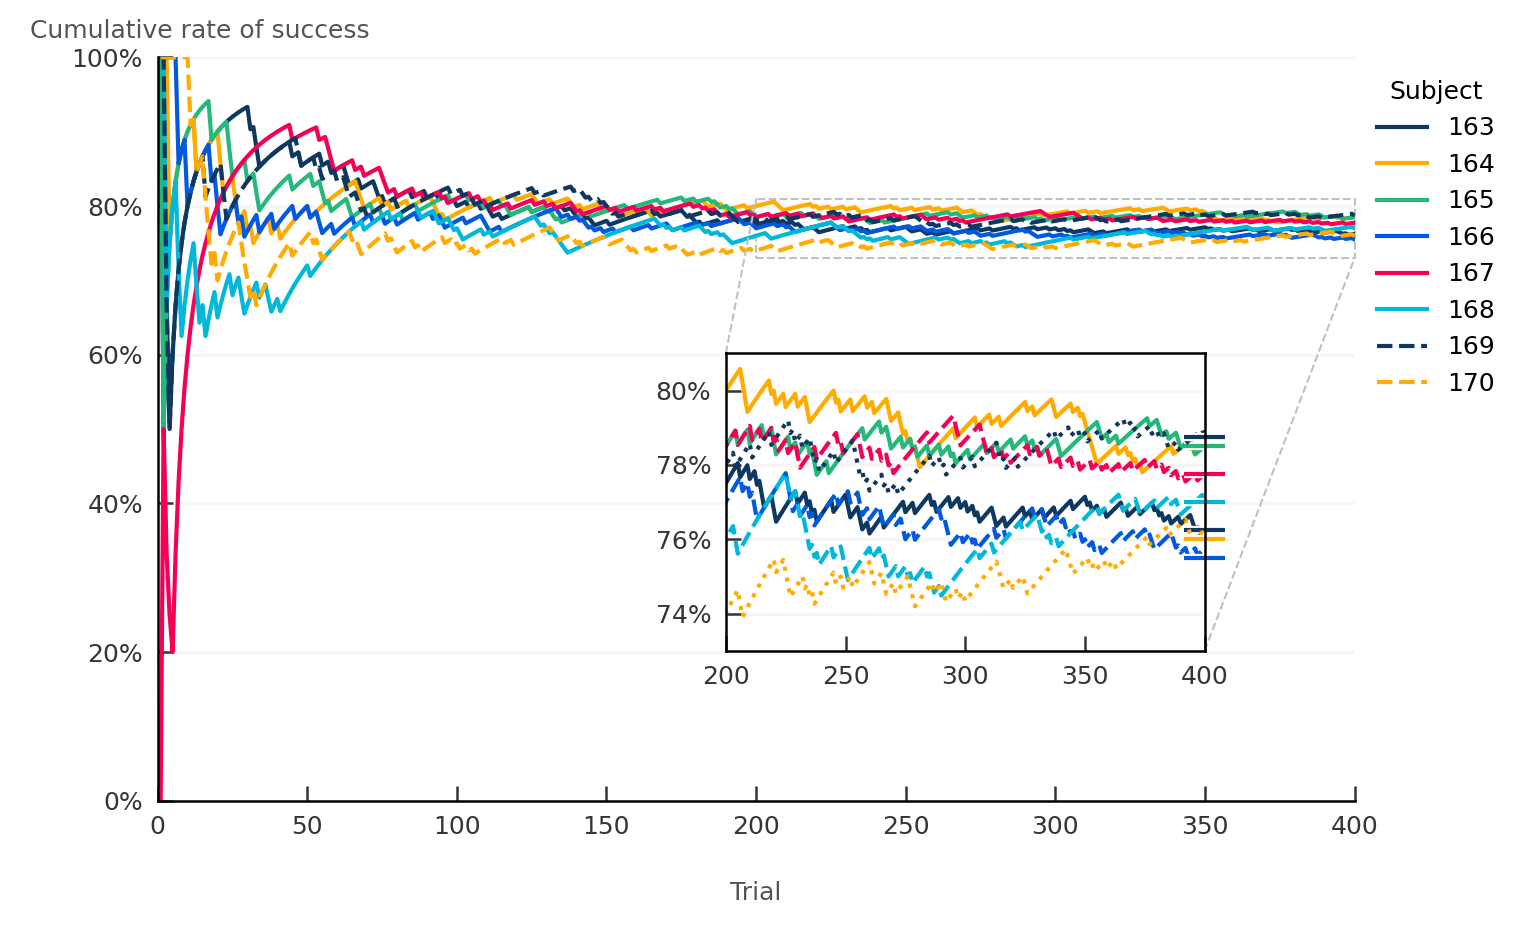

In [34]:
fig, ax = plt.subplots(figsize=(5, 3), ncols=1)

for subject, subject_data in behav_data.groupby("subject"):
    plt.plot(
        subject_data["trial_index"],
        subject_data["responded_correctly"].cumsum() / subject_data["trial_index"],
        label=subject,
        linewidth=1,
    )
plt.legend(
    title="Subject", 
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

plt.xlabel("Trial")
plt.ylabel("Cumulative rate of success", y=1.02, rotation=0, ha="left")
plt.xlim(0, 400)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))

inset_ax = inset_locator.inset_axes(
    plt.gca(),
    width="40%",
    height="40%",
    loc="lower right",
    borderpad=6,
)
inset_ax.spines[["left", "right", "bottom", "top"]].set_visible(True)
inset_locator.mark_inset(
    ax,
    inset_ax,
    edgecolor="silver",
    linewidth=0.5,
    linestyle="dashed",
    alpha=1,
    loc1=2,
    loc2=4,
    clip_on=False,
)
for idx, (subject, subject_data) in enumerate(behav_data.groupby("subject")):
    inset_ax.plot(
        subject_data["trial_index"],
        subject_data["responded_correctly"].cumsum() / subject_data["trial_index"],
        color=f"C{idx}",
        label=subject,
        linewidth=1,
    )
    inset_ax.plot(
        [400],
        subject_data["responded_correctly"].sum() / len(subject_data),
        marker="_",
        markersize=10,
        color=f"C{idx}",
        clip_on=False,
        path_effects=([
            patheffects.Stroke(linewidth=2, foreground="white"), 
            patheffects.Normal(),
        ]),
    )
inset_ax.set_xlim(200, 400)
inset_ax.set_ylim(0.73, 0.81)
inset_ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
# inset_ax.set_ylim(
    # behav_data[behav_data["trial_index"] > 200]["responded_correctly"].min() - 0.01,
    # behav_data[behav_data["trial_index"] > 200]["responded_correctly"].max() + 0.01,
# )
inset_ax.grid(True, axis="y")
# inset_ax.set_title("Final 200 trials", size=6, fontweight="regular", y=1, va="top")
# fig.suptitle("Objective Task Success Rate")

plt.show()

### Objective task response times

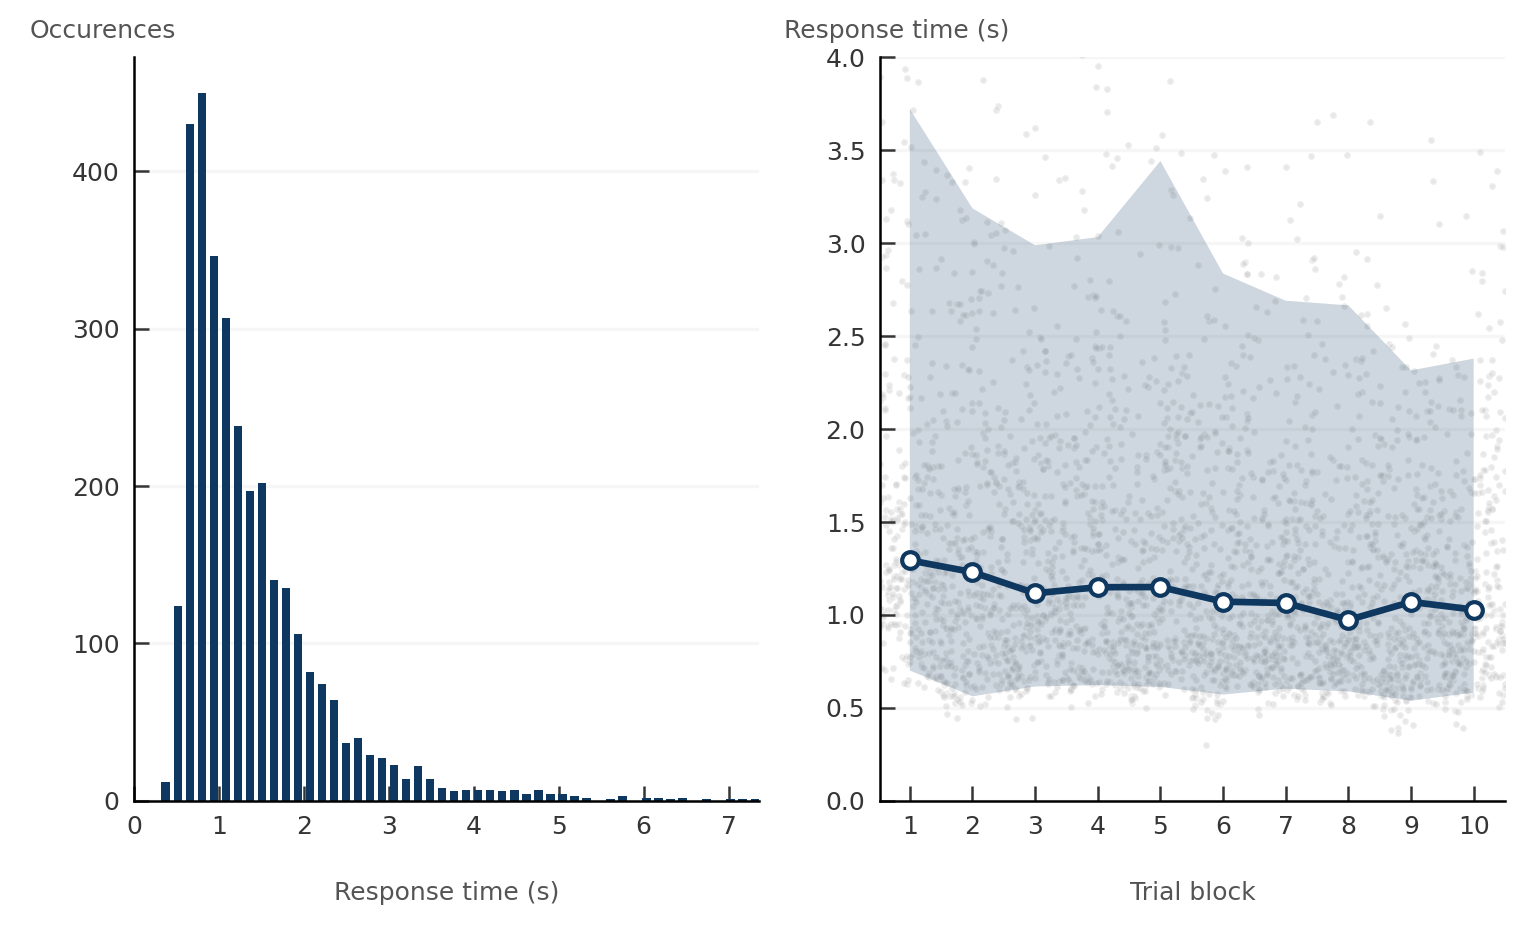

In [35]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)

plt.sca(axes[0])
plt.hist(
    behav_data["response_time"],
    bins=50,
    rwidth=0.7,
)
plt.xlabel("Response time (s)")
plt.ylabel("Occurences", y=1.02, rotation=0, ha="left")
plt.xlim(left=0)

plt.sca(axes[1])
binned_trials = behav_data.groupby("trial_block")["response_time"]
plt.scatter(
    behav_data["trial_index"] / 40,
    behav_data["response_time"],
    marker=".",
    s=10,
    facecolor="grey",
    color="white",
    alpha=0.2,
    # clip_on=False,
    zorder=-1,
)
plt.fill_between(
    np.array(list(binned_trials.groups.keys())) + 0.5,
    binned_trials.apply(np.quantile, q=0.05),
    binned_trials.apply(np.quantile, q=0.95),
    interpolate=True,
    linewidth=0,
    alpha=0.2,
    zorder=1,
    clip_on=False,
)
plt.plot(
    np.array(list(binned_trials.groups.keys())) + 0.5,
    binned_trials.median(),
    marker="o",
    markerfacecolor="white",
    zorder=10,
    clip_on=False,
)
plt.xlabel("Trial block")
plt.ylabel("Response time (s)", y=1.02, rotation=0, ha="left")
plt.xticks(np.arange(10) + 0.5, range(1, 10 + 1))
# plt.xlim(0, 9)
plt.ylim(
    bottom=0,
    top=4,
)
# plt.yscale("log")
# fig.suptitle("Objective Task Response Times")

plt.show()

### Subjective experience and stimulus discrimination performance

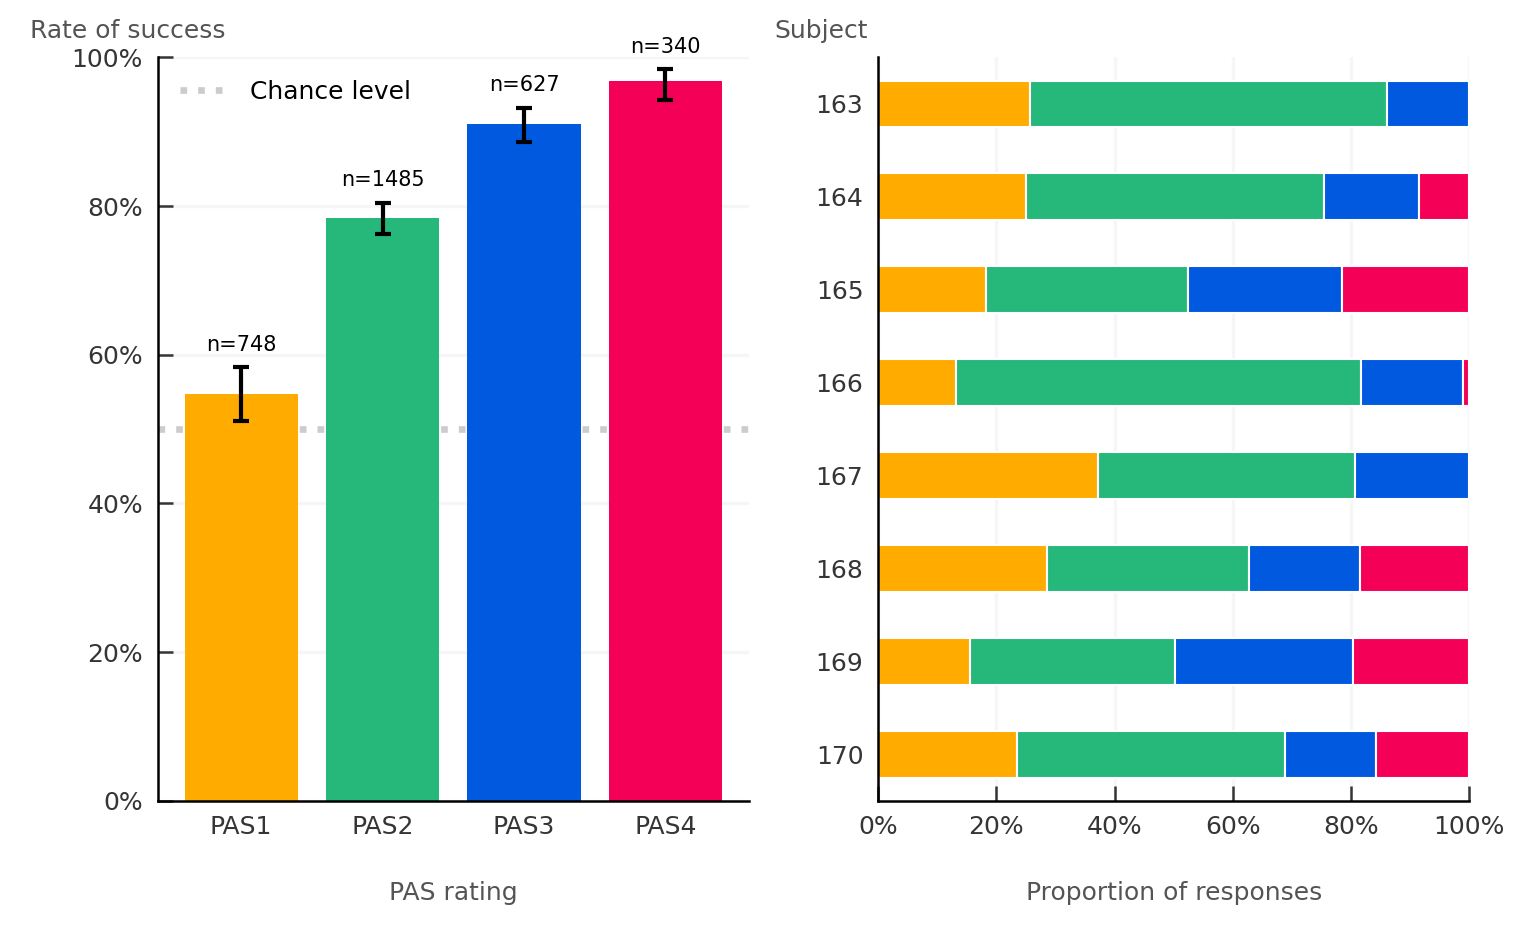

In [36]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)

plt.sca(axes[0])
for PAS, response_data in behav_data.groupby("PAS")["responded_correctly"].agg(["size", "sum", "mean"]).iterrows():
    plt.bar(
        x=PAS,
        height=response_data["mean"],
        color=f"C{PAS}",
    )
    low, high = stats.binomtest(response_data["sum"].astype(int), response_data["size"].astype(int)).proportion_ci(0.95)
    plt.errorbar(
        x=PAS,
        y=response_data["mean"],
        yerr=[[response_data["mean"] - low], [high - response_data["mean"]]],
        color="black",
        elinewidth=1,
        capsize=2,
        zorder=3,
    )
    plt.annotate(
        f"""n={response_data["size"].astype(int)}""",
        xy=(PAS, high),
        ha="center",
        xytext=(0, 4),
        textcoords="offset points",
        size=5,
    )
plt.axhline(
    0.5,
    color="grey",
    linestyle="dotted",
    label="Chance level",
    alpha=0.4,
    zorder=-1,
)
plt.legend()
plt.xticks((1, 2, 3, 4), ["PAS" + str(i) for i in (1, 2, 3, 4)])
plt.xlabel("PAS rating")
plt.ylabel("Rate of success", y=1.02, rotation=0, ha="left")
plt.margins(x=0.05)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.sca(axes[1])
behav_data.groupby("subject")["PAS"].value_counts(normalize=True).reset_index().pivot(index="subject", columns="PAS", values="proportion").sort_index(ascending=False).fillna(0).plot(
    kind="barh",
    stacked=True,
    edgecolor="white",
    linewidth=0.5,
    color=[f"C{i}" for i in range(1, 5)],
    legend=False,
    ax=plt.gca(),
)
plt.xlabel("Proportion of responses")
plt.ylabel("Subject", y=1.02, rotation=0, ha="left")
plt.xlim(0, 1)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
# fig.suptitle("Subjective Responses")

plt.show()

### Stimulus contrast, adaptive staircase

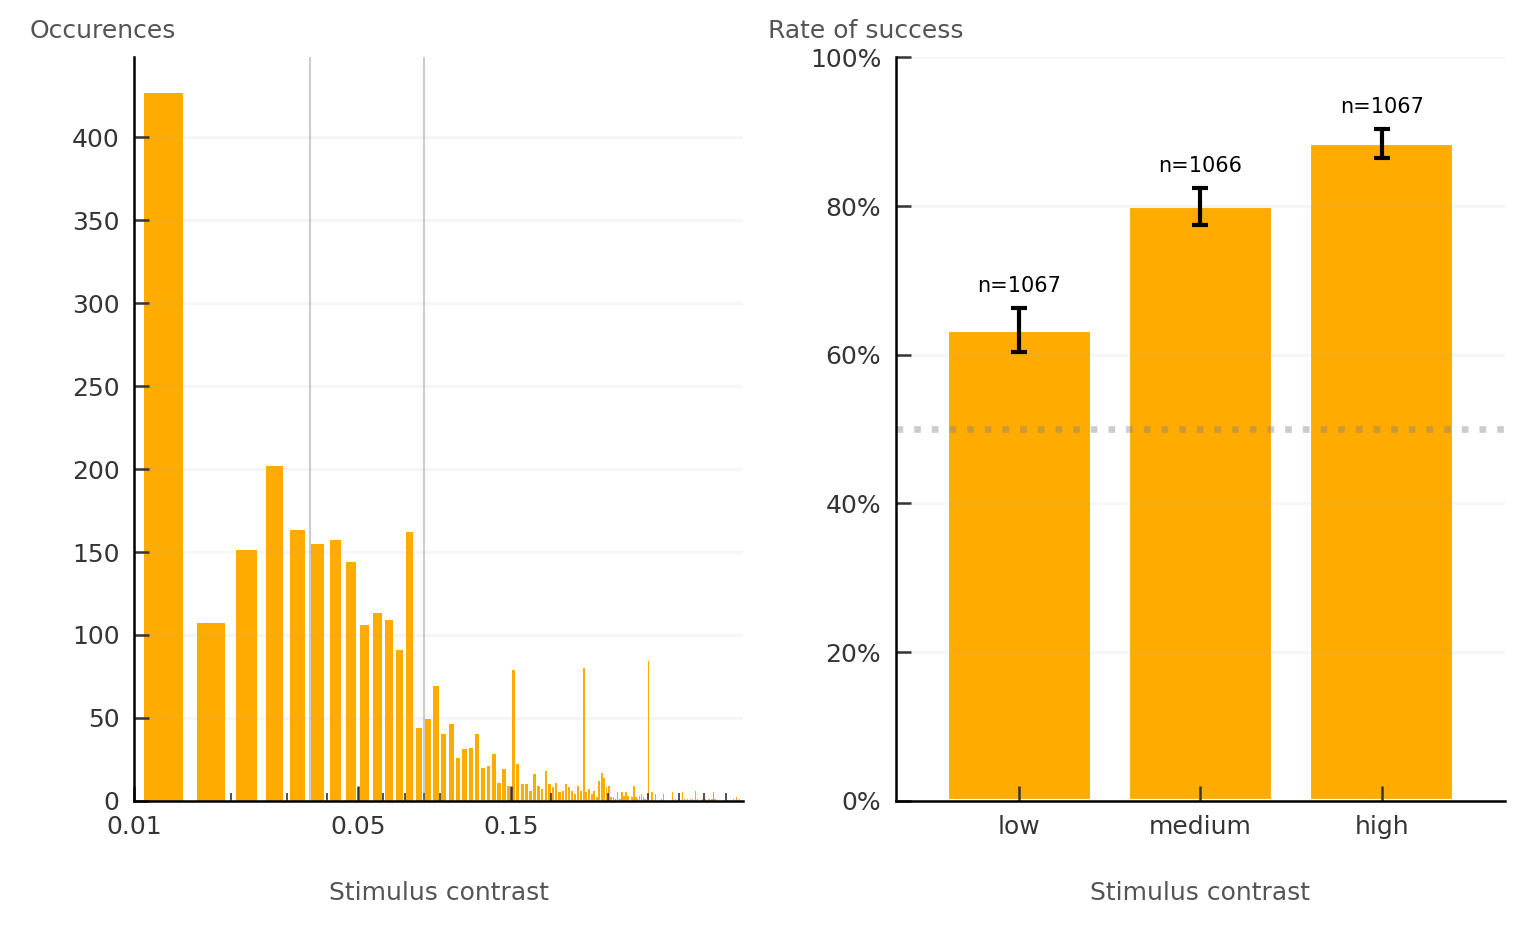

In [37]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)

plt.sca(axes[0])
plt.hist(
    behav_data["target_contrast"],
    bins=np.arange(0, 0.8, 0.005),
    color="C1",
    rwidth=0.7,
    zorder=-1,
)
for bin_edge in contrast_bins[1:-1]:
    plt.axvline(
        bin_edge,
        color="grey",
        alpha=0.4,
        linewidth=0.5,
    )
plt.xlabel("Stimulus contrast")
plt.ylabel("Occurences", y=1.02, rotation=0, ha="left")
# plt.xlim(left=0, right=0.8)
plt.xscale("log", base=10)
plt.xticks([0.01, 0.05, 0.15], [0.01, 0.05, 0.15])
plt.xlim(left=0.01)

plt.sca(axes[1])

plt.bar(
    x=behav_data["contrast_bin"].unique()[::-1],
    height=behav_data.groupby("contrast_bin", observed=False)["responded_correctly"].mean().values,
    # width=0.95 * np.diff(bins),
    linewidth=1,
    edgecolor="white",
    color="C1",
    clip_on=False,
    zorder=-1,
)
for contrast, response_data in behav_data.groupby("contrast_bin", observed=False)["responded_correctly"].agg(["size", "sum", "mean"]).iterrows():
    low, high = stats.binomtest(response_data["sum"].astype(int), response_data["size"].astype(int)).proportion_ci(0.95)
    plt.errorbar(
        x=contrast,
        y=response_data["mean"],
        yerr=[[response_data["mean"] - low], [high - response_data["mean"]]],
        color="black",
        elinewidth=1,
        capsize=2,
        zorder=3,
        clip_on=False,
    )
    plt.annotate(
        f"""n={response_data["size"].astype(int)}""",
        xy=(contrast, high),
        ha="center",
        xytext=(0, 4),
        textcoords="offset points",
        size=5,
    )
plt.axhline(
    0.5,
    color="grey",
    linestyle="dotted",
    label="Chance level",
    alpha=0.4,
    zorder=-1,
)
# plt.legend()
plt.xlabel("Stimulus contrast")
plt.ylabel("Rate of success", y=1.02, rotation=0, ha="left")
plt.margins(x=0.1)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
# fig.suptitle("Stimulus Contrast")

plt.show()

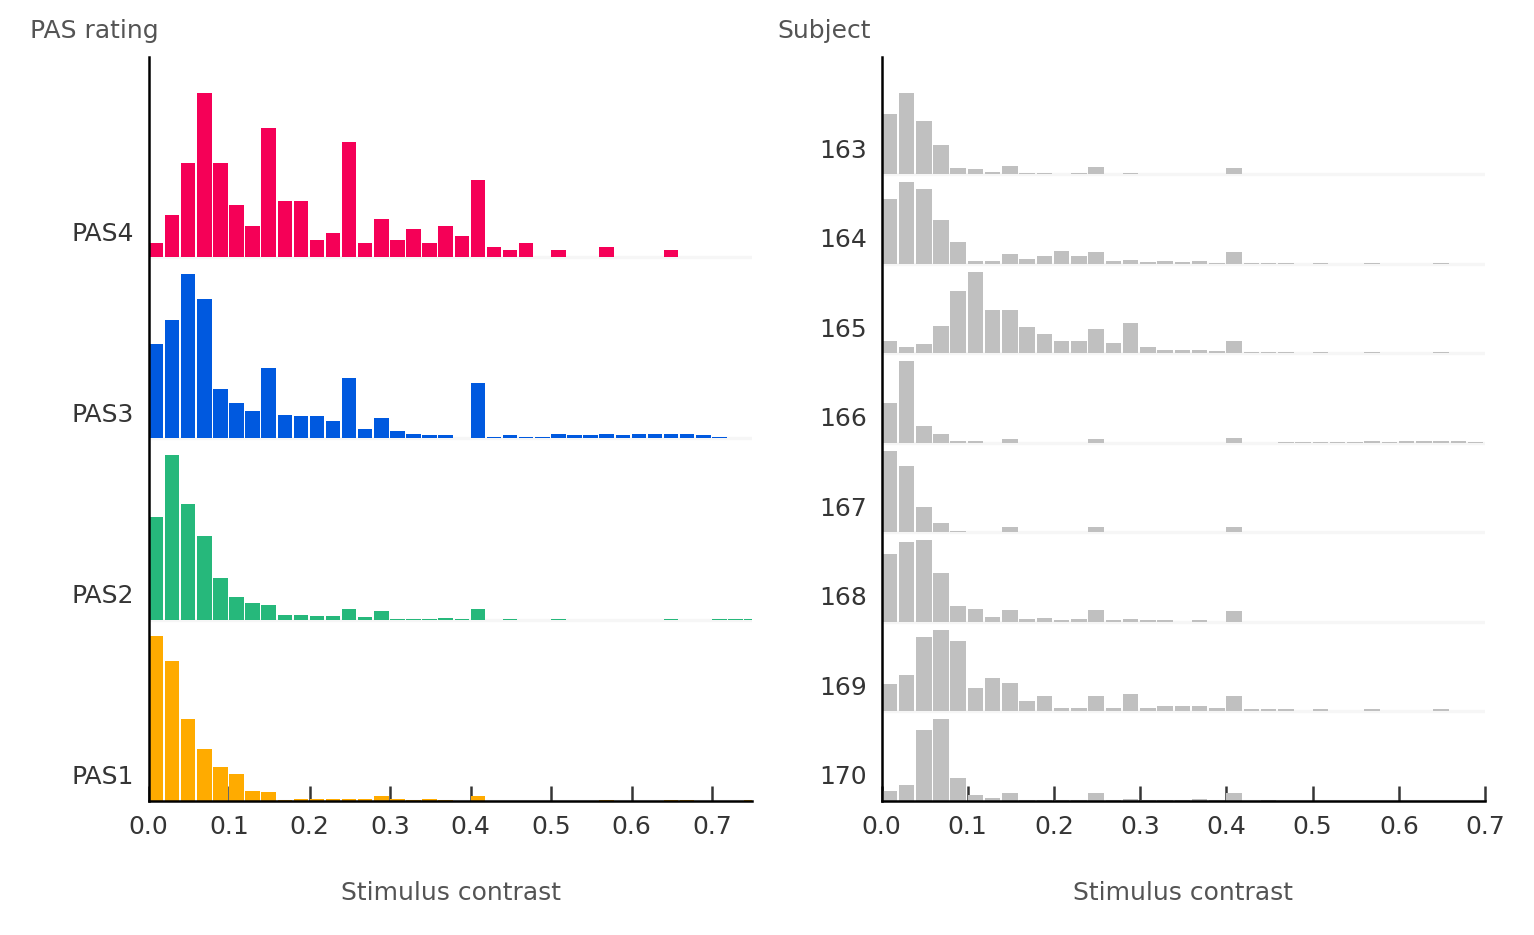

In [ ]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)

plt.sca(axes[0])
for row_idx, (PAS, response_data) in enumerate(behav_data.groupby("PAS")):
    hist, bin_edges = np.histogram(
        response_data["target_contrast"],
        bins=np.linspace(0, 1, 51),
    )
    plt.bar(
        x=bin_edges[:-1],
        height=np.array(hist) / max(hist) / 1.1,
        bottom=row_idx,
        width=0.018,
        color=f"C{PAS}",
        align="edge",
    )

plt.yticks(np.arange(4), [f"PAS{i}\n\n" for i in (1, 2, 3, 4)])
plt.tick_params(axis="y", left=False)
plt.xlabel("Stimulus contrast")
plt.ylabel("PAS rating", y=1.02, rotation=0, ha="left")
plt.xlim(0, 0.75)

plt.sca(axes[1])
for row_idx, (subject, response_data) in enumerate(behav_data.groupby("subject")):
    hist, bin_edges = np.histogram(
        response_data["target_contrast"],
        bins=np.linspace(0, 1, 51),
    )
    plt.bar(
        x=bin_edges[:-1],
        height=np.array(hist) / max(hist) / 1.1,
        bottom=row_idx,
        width=0.018,
        color="silver",
        align="edge",
    )

plt.yticks(range(behav_data["subject"].nunique()), [f"{subject}\n\n" for subject in behav_data["subject"].sort_values(ascending=False).unique()])
plt.tick_params(axis="y", left=False)
plt.xlabel("Stimulus contrast")
plt.ylabel("Subject", y=1.02, rotation=0, ha="left")
plt.xlim(0, 0.7)

plt.show()

## Hierarchical modeling

Bayesian model comparison, based on ELPD (expected log pointwise predictive density) with leave-one-out cross-validation, indicated that a model incorporating random slopes for PAS score per subject was superior to considering only random intercepts across subjects [(Spiegelhalter et al., 2002)](https://doi.org/10.1111/1467-9868.00353):

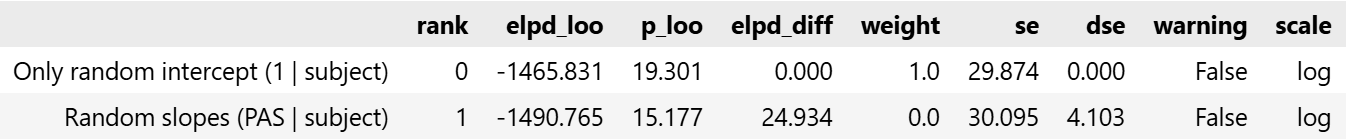

This implies that subjects tended to have idiosyncratic/differ in their conceptual understandings as to the meaning of each of the four PAS scores: 

Modeling the probability that responded_correctly==1


       Formula: responded_correctly ~ 0 + PAS*scale(target_contrast) + target_response + trial_block + (PAS | subject)
        Family: bernoulli
          Link: p = logit
  Observations: 3200
        Priors: 
    target = p
        Common-level effects
            PAS ~ Normal(mu: 0.0, sigma: 3.0)
            scale(target_contrast) ~ Normal(mu: 0.0, sigma: 1.0)
            PAS:scale(target_contrast) ~ Normal(mu: 0.0, sigma: 1.0)
            target_response ~ Normal(mu: 0.0, sigma: 0.1)
            trial_block ~ Normal(mu: 0.0, sigma: 0.1)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: Exponential(lam: 5.0))
            PAS|subject ~ Normal(mu: 0.0, sigma: Exponential(lam: 15.0))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [PAS, scale(target_contrast), PAS:scale(target_contrast), target_response, trial_block, 1|subject_sigma, 1|subject_offset, PAS|subject_sigma, PAS|subject_offset]


Output()

Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 39 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_2%  hdi_98%  mcse_mean  \
PAS[1]                         0.181  0.124  -0.070    0.431      0.003   
PAS[2]                         1.533  0.216   1.040    1.963      0.008   
PAS[3]                         2.600  0.240   2.103    3.092      0.006   
PAS[4]                         3.074  0.335   2.396    3.744      0.007   
scale(target_contrast)         0.073  0.122  -0.168    0.325      0.003   
PAS:scale(target_contrast)[2]  0.708  0.200   0.315    1.137      0.004   
PAS:scale(target_contrast)[3]  1.829  0.388   1.081    2.668      0.009   
PAS:scale(target_contrast)[4]  0.682  0.380  -0.063    1.472      0.008   
target_response[right]        -0.042  0.066  -0.188    0.084      0.001   
trial_block                    0.014  0.017  -0.020    0.046      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
PAS[1]                           0.002    1496.0    1588.0   1.00  
PAS[2]                           0.005     736.0    1037.0   1.00  
PAS[3]                           0.005    1641.0    1256.0   1.00  
PAS[4]                           0.007    2665.0    2135.0   1.00  
scale(target_contrast)           0.002    1943.0    2048.0   1.00  
PAS:scale(target_contrast)[2]    0.003    2246.0    2006.0   1.00  
PAS:scale(target_contrast)[3]    0.008    2004.0    1652.0   1.00  
PAS:scale(target_contrast)[4]    0.007    2487.0    2172.0   1.01  
target_response[right]           0.001    3455.0    2297.0   1.00  
trial_block                      0.000    1872.0    2201.0   1.00

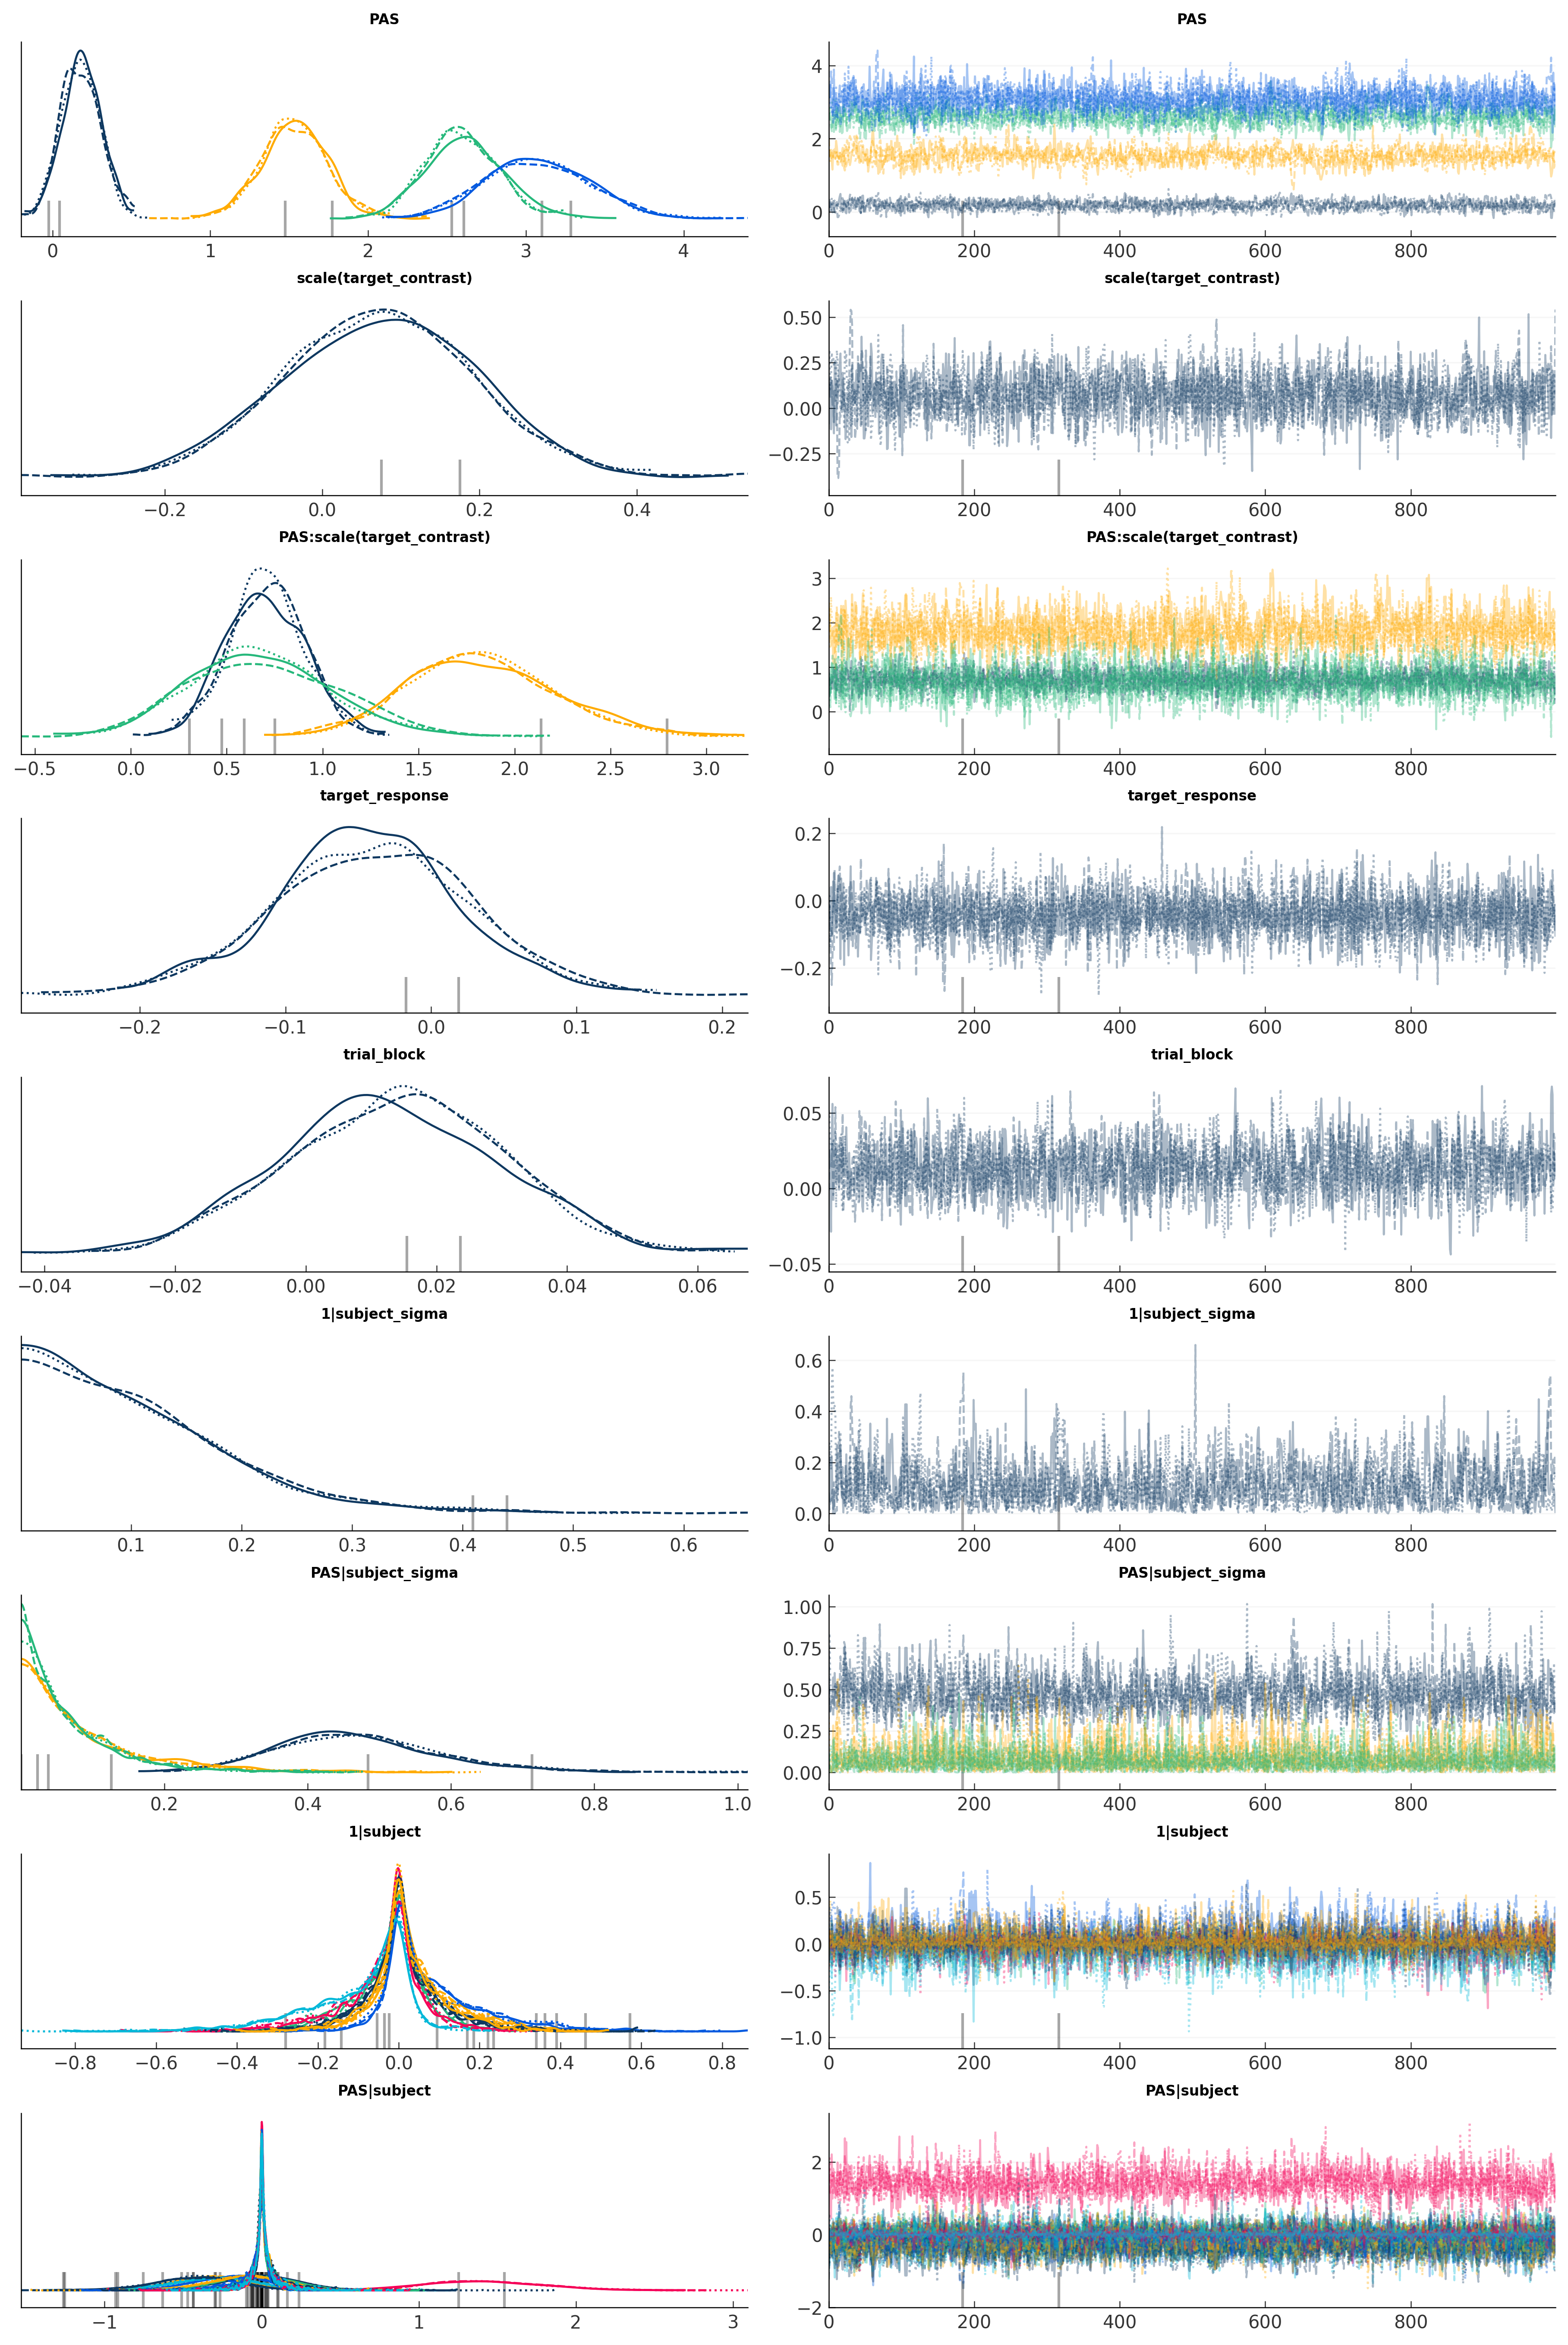

In [39]:
model = bmb.Model(
    data=behav_data,
    formula="responded_correctly ~ " + " + ".join([
        "0",
        "PAS*scale(target_contrast)",
        "target_response",
        "trial_block",
        "(PAS | subject)",
    ]),
    family="bernoulli",
    link="logit",
    categorical=[
        "PAS",
        "target_response",
        "subject",
    ],
    priors={
        "PAS": bmb.Prior("Normal", mu=0, sigma=3),
        "scale(target_contrast)": bmb.Prior("Normal", mu=0, sigma=1),
        "PAS:scale(target_contrast)": bmb.Prior("Normal", mu=0, sigma=1),
        "target_response": bmb.Prior("Normal", mu=0, sigma=0.1),
        "trial_block": bmb.Prior("Normal", mu=0, sigma=0.1),
        "1|subject": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=5)),
        "PAS|subject": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=15)),
    },
)
print(model)

fit = model.fit(
    chains=3,
    cores=3,
    tune=500,
    draws=1000,
    random_seed=0,
)

az.plot_trace(fit)
az.summary(fit, var_names="~.*\\|.*", filter_vars="regex")

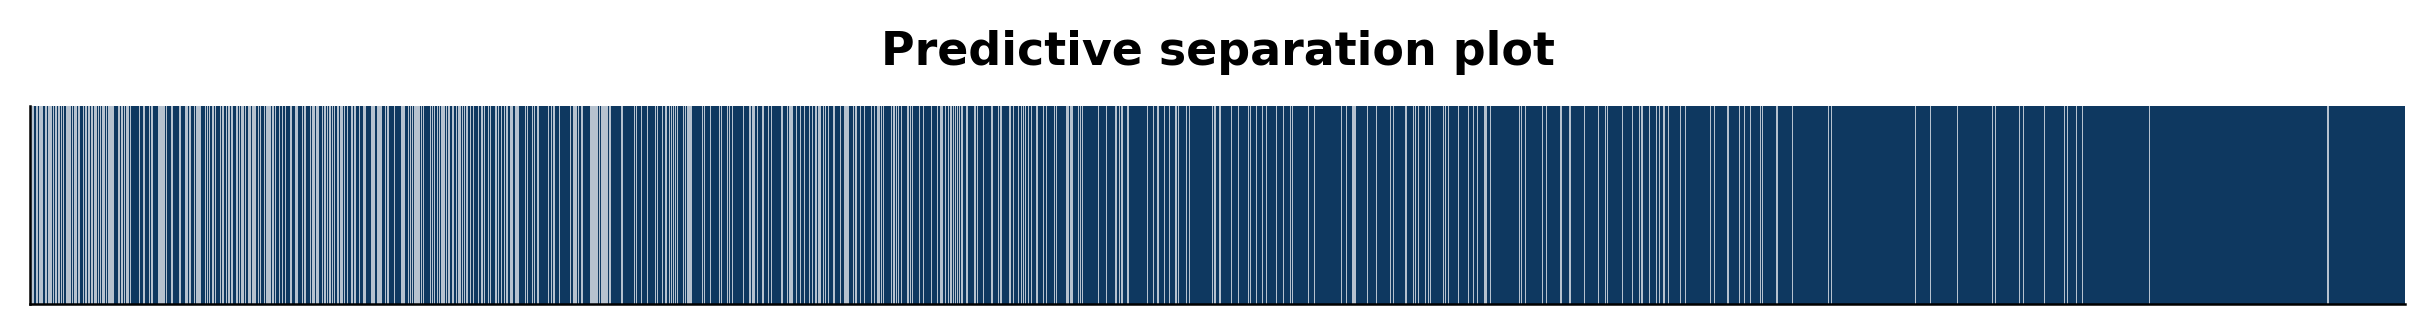

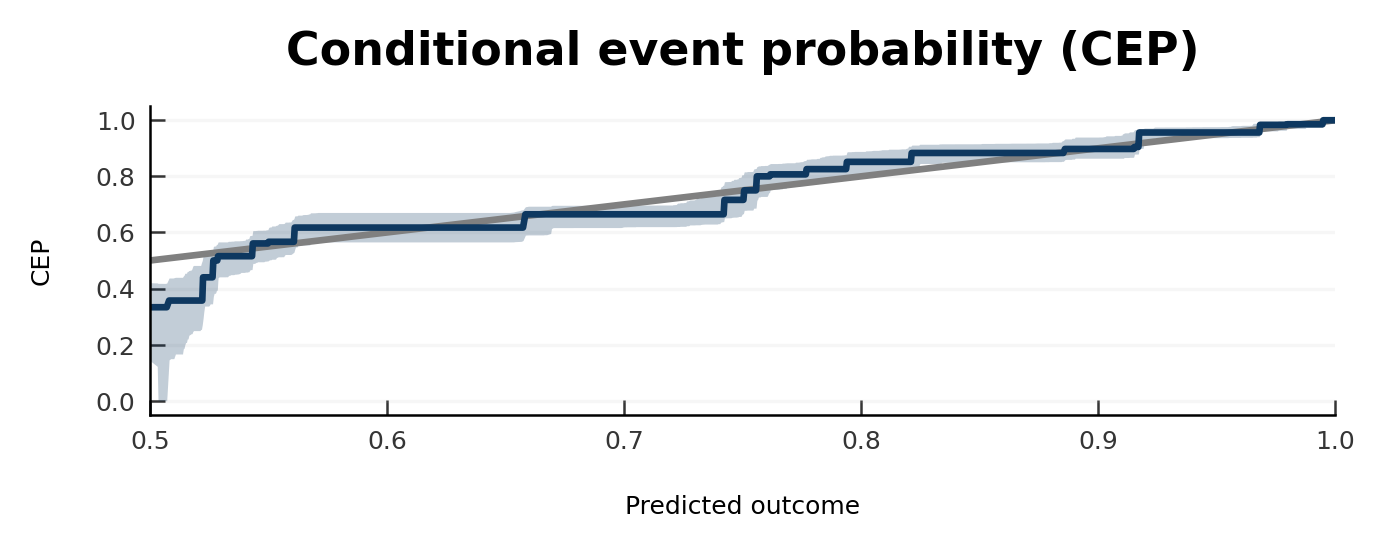

In [40]:
model.predict(fit, kind="response", inplace=True)
az.plot_separation(
    idata=fit,
    y="responded_correctly",
    y_hat="responded_correctly", 
    figsize=(8, 1),
)
plt.title("Predictive separation plot")
plt.show()
azp.plot_ppc_pava(
    fit,
)
plt.xlabel("Predicted outcome")
plt.title("Conditional event probability (CEP)")
plt.show()

### Model predictions

Default computed for unspecified variable: target_contrast, target_response, trial_block
Default computed for unspecified variable: target_contrast, target_response, trial_block
Default computed for unspecified variable: target_contrast, target_response, trial_block
Default computed for unspecified variable: target_contrast, target_response, trial_block


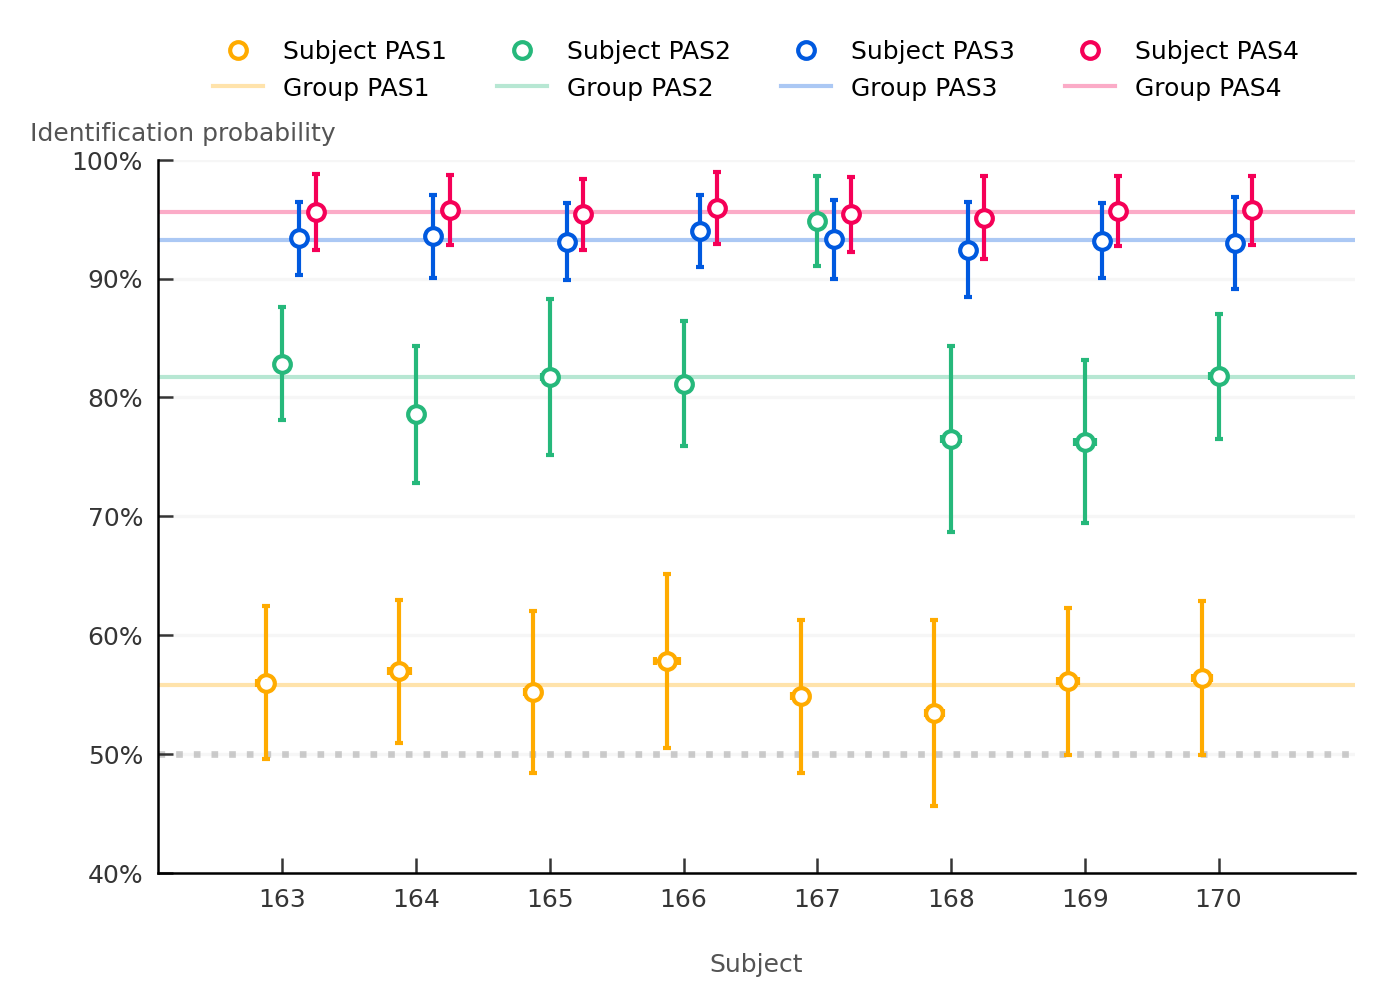

In [ ]:
fig, ax = plt.subplots()

for PAS in (1, 2, 3, 4):
    predictions = bmb.interpret.predictions(
        model,
        fit,
        conditional=dict(
            PAS=PAS,
            subject=behav_data["subject"].sort_values().unique(),
        ),
        prob=az.rcParams["stats.ci_prob"],
    ).rename(columns=lambda col_name: col_name.split("_")[0] if "%" in col_name else col_name)
    ax.plot(
        predictions["subject"].astype(int) - 0.25 + PAS / 8,
        predictions["estimate"],
        marker="o",
        color=f"C{PAS}",
        markerfacecolor="white",
        markeredgecolor=f"C{PAS}",
        label=f"Subject PAS{PAS}",
        linestyle="none",
        zorder=10,
    )
    ax.errorbar(
        predictions["subject"].astype(int) - 0.25 + PAS / 8,
        predictions["estimate"],
        predictions["estimate"] - predictions["lower"],
        predictions["upper"] - predictions["estimate"],
        color=f"C{PAS}",
        elinewidth=1,
        linewidth=0,
        capsize=1,
        zorder=5,
    )
    print(predictions["estimate"].mean()
    ax.axhline(
        predictions["estimate"].mean(),
        color=f"C{PAS}",
        label=f"Group PAS{PAS}",
        linewidth=1,
        alpha=0.33,
    )

    ax.set_ylim(0.4, 1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_ylabel("Identification probability", y=1.02, rotation=0, ha="left")
    ax.margins(x=0.1)

ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.2))
ax.axhline(
    0.5,
    color="grey",
    linestyle="dotted",
    label="Chance level",
    alpha=0.4,
    zorder=-1,
)
ax.set_xticks(behav_data["subject"].sort_values().unique())
ax.set_xlabel("Subject")
# ax.set_title("Subject Differences", y=1.15)

plt.show()

Default computed for unspecified variable: subject, target_contrast, target_response
Default computed for unspecified variable: subject, target_contrast, target_response
Default computed for unspecified variable: subject, target_contrast, target_response
Default computed for unspecified variable: subject, target_contrast, target_response


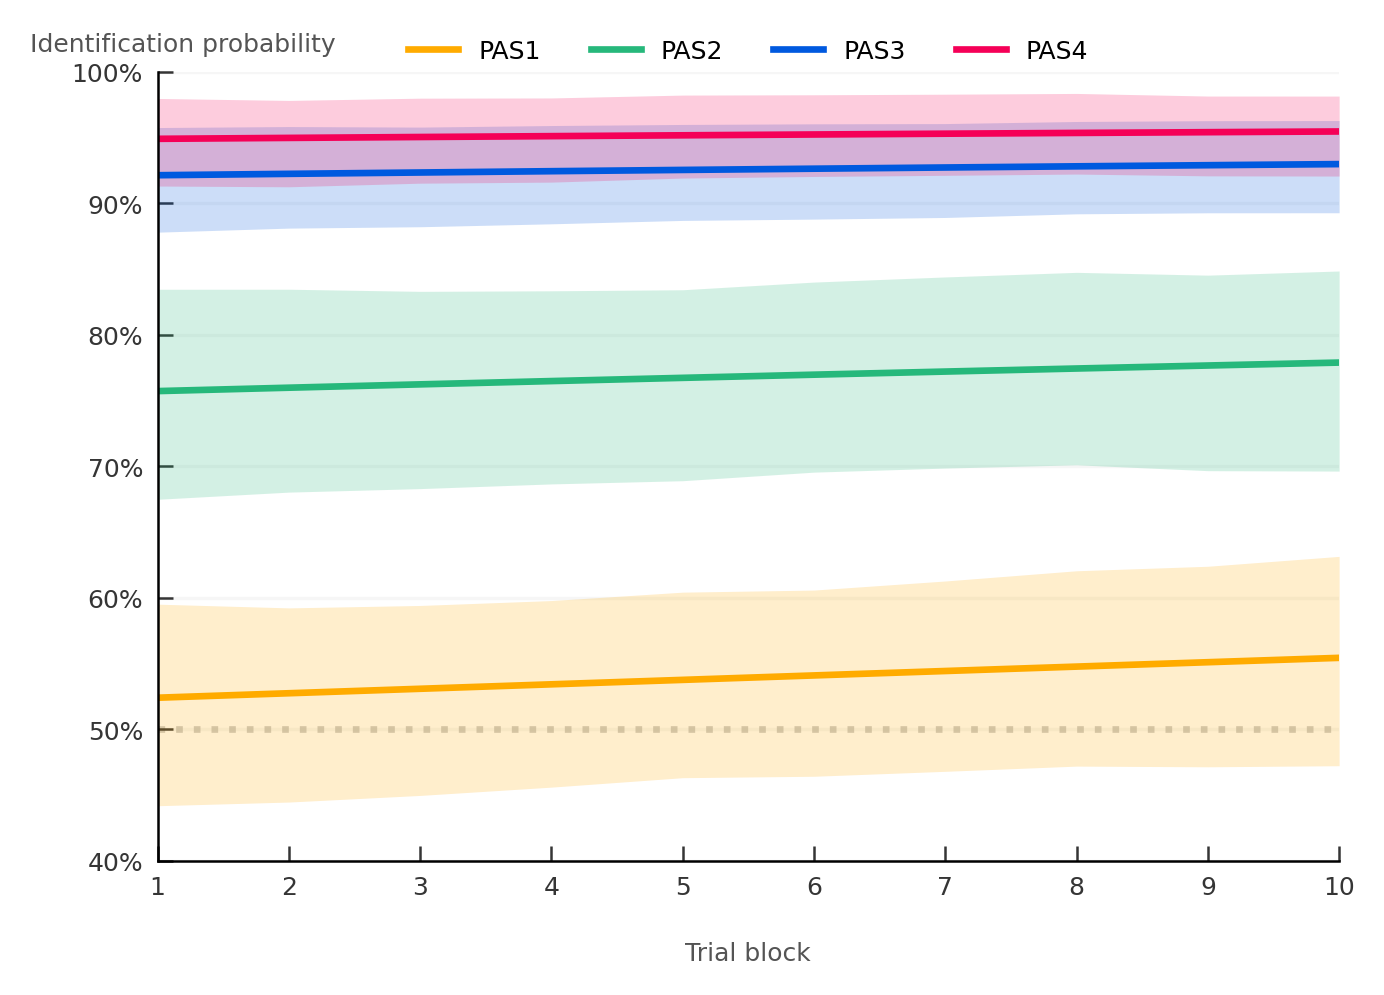

In [42]:
fig, ax = plt.subplots()

for PAS in (1, 2, 3, 4):
    predictions = bmb.interpret.predictions(
        model,
        fit,
        conditional=dict(
            PAS=PAS,
            trial_block=np.arange(1, 10 + 1),
        ),
    ).rename(columns=lambda col_name: col_name.split("_")[0] if "%" in col_name else col_name)
    ax.plot(
        predictions["trial_block"],
        predictions["estimate"],
        # marker="o",
        color=f"C{PAS}",
        label=f"PAS{PAS}",
    )
    ax.fill_between(
        predictions["trial_block"],
        predictions["lower"],
        predictions["upper"],
        color=f"C{PAS}",
        alpha=0.2,
        linewidth=0,
    )
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.07))
# ax.set_title(f"Learning Effects", y=1.02)
ax.axhline(
    0.5,
    color="grey",
    linestyle="dotted",
    label="Chance level",
    alpha=0.4,
    zorder=-1,
)
ax.set_ylim(0.4, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_xlabel("Trial block")
ax.set_ylabel("Identification probability", y=1.02, rotation=0, ha="left")
plt.show()

Default computed for unspecified variable: subject, target_response, trial_block
Default computed for unspecified variable: subject, target_response, trial_block
Default computed for unspecified variable: subject, target_response, trial_block
Default computed for unspecified variable: subject, target_response, trial_block


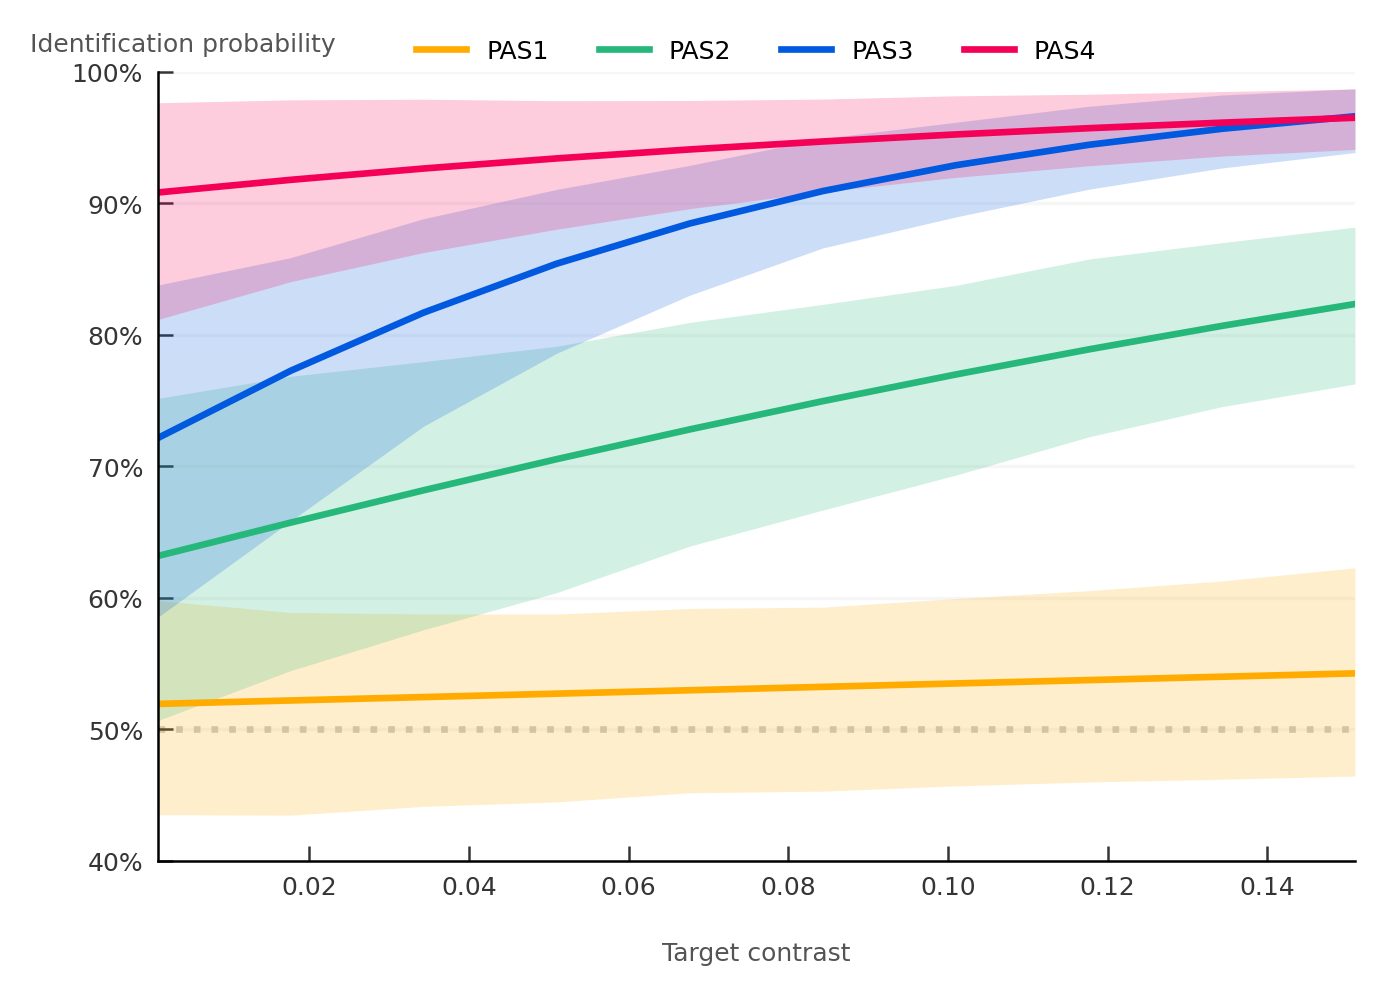

In [43]:
fig, ax = plt.subplots(figsize=(4.5, 3.2))

for PAS in (1, 2, 3, 4):
    predictions = bmb.interpret.predictions(
        model,
        fit,
        conditional=dict(
            PAS=PAS,
            target_contrast=np.linspace(0.001, 0.151, 10),
        ),
    ).rename(columns=lambda col_name: col_name.split("_")[0] if "%" in col_name else col_name)
    ax.plot(
        predictions["target_contrast"],
        predictions["estimate"],
        color=f"C{PAS}",
        label=f"PAS{PAS}",
    )
    ax.fill_between(
        predictions["target_contrast"],
        predictions["lower"],
        predictions["upper"],
        color=f"C{PAS}",
        linewidth=0,
        alpha=0.2,
    )

# ax.set_title("Target Contrast Effects", y=1.02)
ax.set_xlabel("Target contrast")
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.07))
ax.axhline(
    0.5,
    color="grey",
    linestyle="dotted",
    label="Chance level",
    alpha=0.4,
    zorder=-1,
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_ylim(0.4, 1)
ax.set_ylabel("Identification probability", y=1.02, rotation=0, ha="left")

plt.show()

In [1]:
%load_ext watermark
%watermark -iv -v -m

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.5.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.186.el8
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

